In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import toad
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
#from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

# Import Data

In [ ]:
import os
from pathlib import Path

def smart_read_csv(relative_path: str, in_drive: bool = False):
    """
    智能读取 CSV 文件。

    参数：
        relative_path (str): 相对路径，例如 'risk_management/train.csv'
        in_drive (bool): 如果为 True，则从 Google Drive 读取；否则从当前目录读取。

    返回：
        pandas.DataFrame
    """
    if in_drive:
        # check Google Drive
        drive_mount_point = "/content/drive"
        if not os.path.exists(drive_mount_point):
            from google.colab import drive
            print("⏳ 挂载 Google Drive...")
            drive.mount(drive_mount_point)

        base_path = Path(drive_mount_point) / "My Drive"
    else:
        base_path = Path().resolve()

    file_path = base_path / relative_path

    if not file_path.exists():
        raise FileNotFoundError(f"文件未找到: {file_path}")

    print(f"✅ 正在读取文件: {file_path}")
    return pd.read_csv(file_path)


In [ ]:
data_train =df = smart_read_csv("risk_management/train.csv", in_drive=True)
data_test_a = df = smart_read_csv("risk_management/testA.csv", in_drive=True)

✅ 正在读取文件: /content/drive/My Drive/risk_management/train.csv
✅ 正在读取文件: /content/drive/My Drive/risk_management/testA.csv


#  Feature Preprocessing

Find numerical features and category features

In [ ]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

## Handling missing values

In [ ]:
data_train.isnull().sum()

,0
id,0
loanAmnt,0
term,0
interestRate,0
installment,0
grade,0
subGrade,0
employmentTitle,1
employmentLength,46799
homeOwnership,0


Fill numeric features by average

In [ ]:
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())

Fill categorical features by majority

In [ ]:
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

##  Data type conversion

In [ ]:
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [ ]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test_a]:
    data['employmentLength'].replace('10+ years', '10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

data['employmentLength'].value_counts(dropna=False).sort_index()

,count
employmentLength,
0.0,15989
1.0,13182
2.0,18207
3.0,16011
4.0,11833
5.0,12543
6.0,9328
7.0,8823
8.0,8976


In [ ]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

## Objective data

In [ ]:
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, 'number of features:', data[f].nunique())

grade number of features: 7
subGrade number of features: 35
employmentTitle number of features: 79282
homeOwnership number of features: 6
verificationStatus number of features: 3
purpose number of features: 14
postCode number of features: 889
regionCode number of features: 51
applicationType number of features: 2
initialListStatus number of features: 2
title number of features: 12058
policyCode number of features: 1


In [ ]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [ ]:
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

## Outlier treatment

In [ ]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:True if x > upper_rule or x < lower_rule else False)
    return data

In [ ]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].value_counts())
    print('*'*10)

id_outliers
False    800000
Name: count, dtype: int64
id_outliers  isDefault
False        0            640390
             1            159610
Name: count, dtype: int64
**********
loanAmnt_outliers
False    800000
Name: count, dtype: int64
loanAmnt_outliers  isDefault
False              0            640390
                   1            159610
Name: count, dtype: int64
**********
term_outliers
False    800000
Name: count, dtype: int64
term_outliers  isDefault
False          0            640390
               1            159610
Name: count, dtype: int64
**********
interestRate_outliers
False    794259
True       5741
Name: count, dtype: int64
interestRate_outliers  isDefault
False                  0            637565
                       1            156694
True                   1              2916
                       0              2825
Name: count, dtype: int64
**********
installment_outliers
False    792046
True       7954
Name: count, dtype: int64
installment_outliers  isDef

In [ ]:
for fea in numerical_fea:
    data_train=data_train[~data_train[fea+'_outliers']]
    data_train=data_train.reset_index(drop=True)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612742 entries, 0 to 612741
Data columns (total 89 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           612742 non-null  int64         
 1   loanAmnt                     612742 non-null  float64       
 2   term                         612742 non-null  int64         
 3   interestRate                 612742 non-null  float64       
 4   installment                  612742 non-null  float64       
 5   grade                        612742 non-null  int64         
 6   subGrade                     612742 non-null  object        
 7   employmentTitle              612742 non-null  float64       
 8   employmentLength             577657 non-null  float64       
 9   homeOwnership                612742 non-null  int64         
 10  annualIncome                 612742 non-null  float64       
 11  verificationStatus        

In [ ]:
# delete *_outliers
data_train = data_train.drop(columns=[col for col in data_train.columns if col.endswith('_outliers')])

# Feature Creation

In [ ]:
for col in ['grade', 'subGrade']:
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
def construct_ratio_features(df):
    """Create ratio and cross features"""
    df['installment_term_revolBal'] = df['installment']*12*df['term']/(df['revolBal'] + 0.1)
    df['revolUtil_revolBal'] = df['revolUtil']/(df['revolBal'] + 0.1)
    df['openAcc_totalAcc'] = df['openAcc']/df['totalAcc']
    df['dti'] = np.abs(df['dti'].fillna(1000))
    df['loanAmnt_dti_annualIncome'] = df['loanAmnt'] / (np.abs(df['dti'])*df['annualIncome'] + 0.1)
    df['annualIncome_loanAmnt'] = df['annualIncome'] / (df['loanAmnt'] + 0.1)
    df['revolBal_loanAmnt'] = df['revolBal'] / (df['loanAmnt'] + 0.1)
    df['revolBal_installment'] = df['revolBal'] / (df['installment'] + 0.1)
    df['annualIncome_installment'] = df['annualIncome'] / (df['installment'] + 0.1)
    return df

In [ ]:
for df in [data_train, data_test_a]:
    df = construct_ratio_features(df)

# Feature Binning

In [ ]:
data_train_copy = data_train.copy()
data_test_a_copy = data_test_a.copy()

In [ ]:

def bin_and_encode_features(dfs, features_bins):

    # 合并所有数据，统一计算分位数边界
    concated_df = pd.concat(dfs).reset_index(drop=True)

    for feature, bins in features_bins.items():
        labels = list(range(bins))
        # 计算等频分箱，duplicates='drop'避免边界重复导致报错
        binned = pd.qcut(concated_df[feature], q=bins, labels=labels, duplicates='drop')

        # 编码为整数
        binned_codes = binned.astype('category').cat.codes

        start = 0
        for df in dfs:
            end = start + len(df)
            # 分箱标签
            df[feature + '_bin'] = binned[start:end].values
            # 编码结果
            df[feature + '_bin_code'] = binned_codes[start:end].values
            start = end

    return dfs


In [ ]:
dfs=[data_train, data_test_a]
features_bins = {
        'annualIncome': 10,
        'loanAmnt': 10,
        'revolBal': 100,
        'dti': 100,
        'installment': 100,
        'revolUtil': 100
    }
dfs = bin_and_encode_features(dfs, features_bins)

#  Feature Encoding

In [ ]:
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding finished')

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]

Label Encoding finished


# Feature Selection

In [ ]:
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [ ]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [ ]:
numerical_fea=['loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

<Axes: title={'center': 'Correlation of Numeric Features with Price'}>

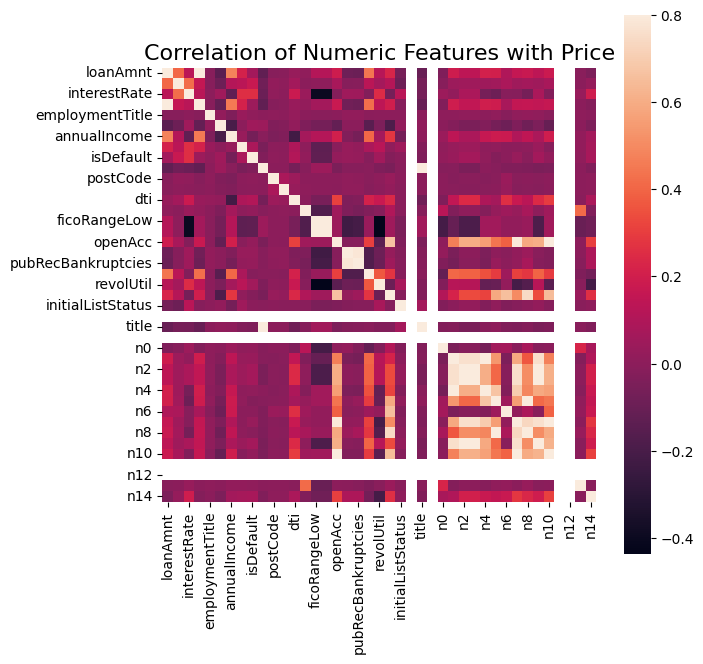

In [ ]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [ ]:
import toad

In [ ]:
feat_lst = list(data_test_a.columns[1:])
psi_df = toad.metrics.PSI(data_train[feat_lst], data_test_a[feat_lst])
psi_df

,0
term,3.191943e-06
interestRate,8.572939e-03
installment,1.919715e-01
grade,3.966490e-03
subGrade,4.569512e-03
employmentTitle,1.327550e-01
employmentLength,4.157204e-04
homeOwnership,9.843183e-04
annualIncome,3.700100e-02
verificationStatus,1.800663e-03


In [ ]:
psi_sorted = psi_df.sort_values(ascending=False)

print(psi_sorted)

revolBal                 2.407367e-01
installment              1.919715e-01
employmentTitle          1.327550e-01
title                    1.173302e-01
annualIncome             3.700100e-02
dti                      3.034743e-02
openAcc                  3.024758e-02
totalAcc                 2.890692e-02
n10                      1.951060e-02
revolBal_bin             1.823309e-02
revolBal_bin_code        1.823309e-02
n2                       1.782987e-02
n3                       1.782987e-02
n8                       1.428354e-02
n7                       1.383157e-02
installment_bin_code     1.311334e-02
installment_bin          1.311334e-02
revolUtil                1.292600e-02
n5                       1.069631e-02
n4                       9.263767e-03
issueDateDT              8.829774e-03
interestRate             8.572939e-03
postCode                 6.189775e-03
annualIncome_bin         6.006895e-03
annualIncome_bin_code    6.006895e-03
n1                       5.645048e-03
revolUtil_bi

In [ ]:
high_psi_vars = psi_df[psi_df > 0.2].index.tolist()

print("PSI > 0.2 的变量有：", high_psi_vars)


PSI > 0.2 的变量有： ['revolBal']


In [ ]:
data_train.drop(columns=high_psi_vars, inplace=True)
data_test_a.drop(columns=high_psi_vars, inplace=True)

In [ ]:
obj_cols = data_train.select_dtypes(include=['category']).columns.tolist()
print(obj_cols)

['annualIncome_bin', 'loanAmnt_bin', 'revolBal_bin', 'dti_bin', 'installment_bin', 'revolUtil_bin']


In [ ]:
data_train.drop(columns=obj_cols, inplace=True)
data_test_a.drop(columns=obj_cols, inplace=True)

In [ ]:
data_train.to_csv('/content/drive/My Drive/risk_management/data_train_for_model.csv')
data_test_a.to_csv('/content/drive/My Drive/risk_management/data_test_a_for_model.csv')

# Modeling


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
 num_no_default =data_train.groupby('isDefault')['isDefault'].count()[0]
 num_default = data_train.groupby('isDefault')['isDefault'].count()[1]

 scale_pos_weight=num_no_default/num_default

In [ ]:
scale_pos_weight

np.float64(4.125789478087016)

In [ ]:
features = [col for col in data_train.columns if col != 'isDefault']
X = data_train[features]
y = data_train['isDefault']

In [ ]:
print(features)

['loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome', 'verificationStatus', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT', 'grade_target_mean', 'subGrade_target_mean', 'grade_to_mean_n0', 'grade_to_std_n0', 'grade_to_mean_n1', 'grade_to_std_n1', 'grade_to_mean_n2', 'grade_to_std_n2', 'grade_to_mean_n3', 'grade_to_std_n3', 'grade_to_mean_n4', 'grade_to_std_n4', 'grade_to_mean_n5', 'grade_to_std_n5', 'grade_to_mean_n6', 'grade_to_std_n6', 'grade_to_mean_n7', 'grade_to_std_n7', 'grade_to_mean_n8', 'grade_to_std_n8', 'grade_to_mean_n9', 'grade_to_std_n9', 'grade_to_mean_n10', 'grade_to_std_n1

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
params = {
    'max_depth': 6,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 1,
    'scale_pos_weight': scale_pos_weight,
    'tree_method': 'hist'
}

In [ ]:
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=50,
    seed=42
)

best_num_rounds = len(cv_results)
print(f"best number of rounds: {best_num_rounds}")

[0]	train-auc:0.70535+0.00064	test-auc:0.70234+0.00187
[50]	train-auc:0.72619+0.00028	test-auc:0.71897+0.00189
[100]	train-auc:0.73641+0.00024	test-auc:0.72431+0.00177
[150]	train-auc:0.74308+0.00022	test-auc:0.72681+0.00177
[200]	train-auc:0.74855+0.00034	test-auc:0.72814+0.00176
[250]	train-auc:0.75354+0.00037	test-auc:0.72893+0.00176
[300]	train-auc:0.75805+0.00043	test-auc:0.72939+0.00170
[350]	train-auc:0.76222+0.00041	test-auc:0.72971+0.00172
[400]	train-auc:0.76625+0.00051	test-auc:0.72992+0.00169
[450]	train-auc:0.77016+0.00062	test-auc:0.73010+0.00167
[500]	train-auc:0.77370+0.00059	test-auc:0.73012+0.00166
[550]	train-auc:0.77720+0.00067	test-auc:0.73014+0.00176
[566]	train-auc:0.77824+0.00063	test-auc:0.73012+0.00176
best number of rounds: 517


In [ ]:
drive_checkpoint_dir = "/content/drive/MyDrive/risk_management/risk_checkpoints"
os.makedirs(drive_checkpoint_dir, exist_ok=True)

In [ ]:

callbacks = [
    xgb.callback.TrainingCheckPoint(
        directory=drive_checkpoint_dir,
        name="xgb_model",
        interval=50,  # 每 50 轮保存一次
        #save_optimizer_state=False  # 如果不打算继续训练，可以设为 False
    )
]

In [ ]:
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_rounds,
    evals=[(dtrain, 'train'), (dval, 'valid')],
    verbose_eval=50,
    callbacks=callbacks
)

[0]	train-auc:0.70468	valid-auc:0.70429
[50]	train-auc:0.72491	valid-auc:0.72037
[100]	train-auc:0.73467	valid-auc:0.72610
[150]	train-auc:0.74052	valid-auc:0.72850
[200]	train-auc:0.74529	valid-auc:0.72990
[250]	train-auc:0.74948	valid-auc:0.73087
[300]	train-auc:0.75335	valid-auc:0.73146
[350]	train-auc:0.75688	valid-auc:0.73187
[400]	train-auc:0.76006	valid-auc:0.73210
[450]	train-auc:0.76305	valid-auc:0.73241
[500]	train-auc:0.76618	valid-auc:0.73255
[516]	train-auc:0.76721	valid-auc:0.73264


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [ ]:
y_pred_proba = bst.predict(dval)

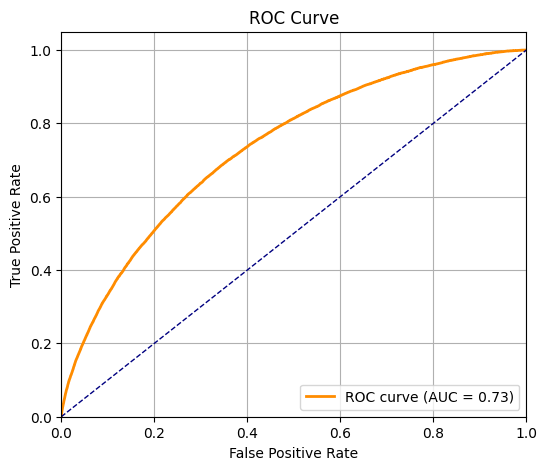

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("/content/drive/MyDrive/risk_management/images/roc_curve_eda.png")
plt.show()

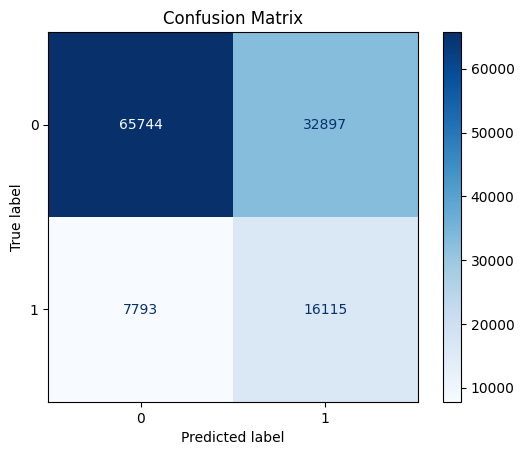

              precision    recall  f1-score   support

           0       0.89      0.67      0.76     98641
           1       0.33      0.67      0.44     23908

    accuracy                           0.67    122549
   macro avg       0.61      0.67      0.60    122549
weighted avg       0.78      0.67      0.70    122549



In [ ]:
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("/content/drive/MyDrive/risk_management/images/confusion_matrix_eda.png")  # 可选保存
plt.show()

print(classification_report(y_val, y_pred))

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

best_f1 = np.max(f1_scores)


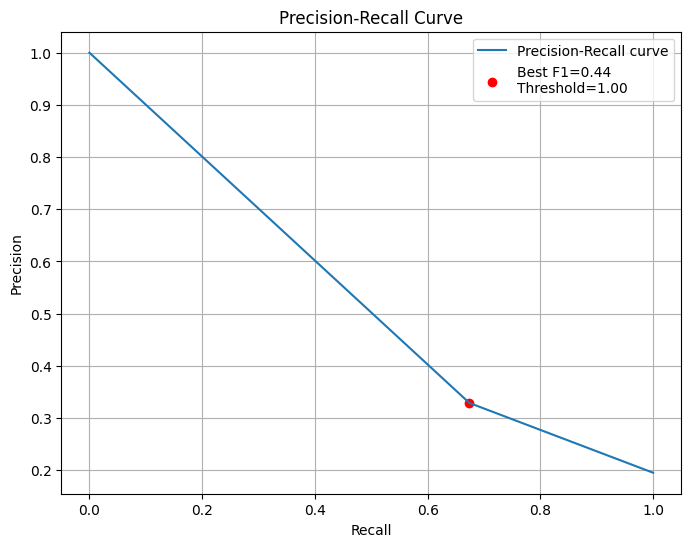

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)],
            marker='o', color='red', label=f'Best F1={best_f1:.2f}\nThreshold={best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("y_pred.min():", y_pred.min())
print("y_pred.max():", y_pred.max())


y_pred.min(): 0
y_pred.max(): 1


In [ ]:
# 清洗
X_test = data_test_a[features].replace([np.inf, -np.inf], np.nan).fillna(-1)

# 构造 DMatrix
dtest = xgb.DMatrix(X_test)


In [ ]:
test_pred = bst.predict(dtest)

In [ ]:
import joblib
joblib.dump(bst, "model_xgb.pkl")

In [ ]:
submit = pd.DataFrame({
    'id': pd.read_csv('/content/drive/My Drive/risk_management/testA.csv')['id'],
    'isDefault': test_pred
})

submit.to_csv('submission.csv', index=False)